<div style="
background-color:#fce4ec;
padding:20px;
border-radius:12px;
border-left:6px solid #c2185b;
margin-bottom:20px;
">

<h2 style="color:#c2185b; margin:0;">
Tương tác Glucose × Giới tính – Độ nhạy glucose có khác biệt giữa nam và nữ?
</h2>

<p style="margin:8px 0 0 0; color:#444; font-style:italic; line-height:1.5;">
Phân tích tác động của mức đường huyết lên nguy cơ đột quỵ có khác biệt giữa nam và nữ
thông qua phương pháp:
<b>Stratified Analysis → Interaction Term → Logistic Regression → Biological Mechanism</b>.
</p>

</div>

<h2 style="
color:#c2185b;
font-weight:700;
border-bottom:3px solid #c2185b;
display:inline-block;
padding-bottom:6px;
margin-bottom:14px;
">
Q4. Tương tác Glucose × Giới tính – Tác động glucose có khác nhau giữa nam và nữ?
</h2>

## Động lực và Lợi ích

### Tại sao câu hỏi này đáng nghiên cứu?

- EDA cho thấy gender × stroke không có mối liên hệ mạnh khi không kiểm soát confounders
- Chưa rõ liệu **độ nhạy với glucose** (glucose sensitivity) có khác biệt giữa nam và nữ
- Nếu có interaction effect → tác động của glucose lên stroke khác nhau giữa 2 giới → gợi ý về cơ chế sinh học
- Phân tích trong nhóm **đã kết hôn** giúp giảm bias về vai trò xã hội và tiếp cận y tế

### Lợi ích và Người quan tâm

- **Bác sĩ:** Xác định ngưỡng glucose cần can thiệp có khác nhau giữa nam và nữ không
- **Nhà nghiên cứu:** Hiểu cơ chế tương tác giữa hormone và chuyển hóa glucose
- **Nhà hoạch định:** Thiết kế chương trình sàng lọc phù hợp theo giới tính

### Giả thuyết

- **H0:** Tác động của glucose lên stroke giống nhau ở nam và nữ (không có interaction)
- **H1:** Tác động của glucose lên stroke khác nhau giữa nam và nữ (có interaction)
- Nếu bác bỏ H0 → độ nhạy glucose khác biệt → gợi ý cơ chế sinh học khác nhau

---

## Phương pháp nghiên cứu

Để kiểm định interaction effect giữa giới tính và glucose:

1. **Tiền xử lý dữ liệu**: Lọc nhóm đã kết hôn, xử lý missing values
2. **Phân tích khám phá (EDA)**: 
   - So sánh tỷ lệ stroke theo giới tính
   - Phân tích theo nhóm glucose - tìm dấu hiệu interaction
3. **Phân tích thống kê**:
   - So sánh 2 mô hình: có vs không có interaction term
   - Stratified analysis: Phân tích riêng nam và nữ
   - Visualization: Vẽ đường dự đoán để thấy rõ interaction
4. **Kết luận**: Trả lời câu hỏi và gợi ý cơ chế sinh học

## A. Tiền xử lý dữ liệu

Các bước xử lý trước khi phân tích:

1. **Load dữ liệu đã cleaned:** Sử dụng healthcare_cleaned.csv

2. **Chuẩn hóa văn bản:** Chuyển các biến categorical về lowercase + strip

3. **Lọc nhóm đã kết hôn:** Chỉ giữ lại những dòng có ever_married = 'yes'

4. **Xử lý missing:** Loại bỏ dòng thiếu avg_glucose_level, impute BMI bằng median

5. **Tạo biến phân loại glucose:** Chia avg_glucose_level thành các nhóm để phân tích

6. **Kiểm tra cân bằng dữ liệu:** Đảm bảo có đủ mẫu cho cả nam và nữ


In [1]:
# Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Cấu hình hiển thị
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Đã import các thư viện thành công!")

Đã import các thư viện thành công!


In [2]:
# Load dữ liệu đã cleaned
df = pd.read_csv('../data/healthcare_cleaned.csv')

print(f"Đã load dữ liệu thành công!")
print(f"Kích thước: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nCác cột: {df.columns.tolist()}")

Đã load dữ liệu thành công!
Kích thước: 5110 rows × 11 columns

Các cột: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


In [3]:
# Chuẩn hóa văn bản
text_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.lower()

# Đổi tên cột để nhất quán
df = df.rename(columns={'Residence_type': 'residence_type'})

# Lọc chỉ nhóm đã kết hôn
df_married = df[df['ever_married'] == 'yes'].copy()

print(f"\nSố dòng trong nhóm đã kết hôn: {df_married.shape[0]}")
print(f"Phân bố giới tính:")
print(df_married['gender'].value_counts())


Số dòng trong nhóm đã kết hôn: 3353
Phân bố giới tính:
gender
female    2001
male      1352
Name: count, dtype: int64


In [4]:
# Xử lý missing values
# Loại bỏ dòng thiếu avg_glucose_level (biến chính trong phân tích)
df_married = df_married.dropna(subset=['avg_glucose_level', 'stroke'])

# Impute BMI bằng median
bmi_median = df_married['bmi'].median()
df_married['bmi_missing_flag'] = df_married['bmi'].isna().astype(int)
df_married['bmi'] = df_married['bmi'].fillna(bmi_median)

# Xử lý smoking_status
df_married['smoking_status'] = df_married['smoking_status'].replace('unknown', np.nan)
valid_smoking = ['never smoked', 'formerly smoked', 'smokes']
df_married['smoking_group'] = df_married['smoking_status'].where(
    df_married['smoking_status'].isin(valid_smoking), np.nan
)

print(f"\nDữ liệu sau xử lý: {df_married.shape}")
print(f"\nPhân bố stroke:")
print(df_married['stroke'].value_counts())
print(f"\nTỷ lệ stroke: {df_married['stroke'].mean()*100:.2f}%")


Dữ liệu sau xử lý: (3353, 13)

Phân bố stroke:
stroke
0    3133
1     220
Name: count, dtype: int64

Tỷ lệ stroke: 6.56%


In [5]:
# Tạo nhóm phân loại glucose để phân tích
def categorize_glucose(glucose):
    """Phân loại mức đường huyết theo tiêu chuẩn y tế"""
    if glucose < 100:
        return 'Bình thường (<100)'
    elif glucose < 126:
        return 'Tiền tiểu đường (100-125)'
    else:
        return 'Tiểu đường (≥126)'

df_married['glucose_category'] = df_married['avg_glucose_level'].apply(categorize_glucose)

print("Phân bố nhóm đường huyết:")
print(df_married['glucose_category'].value_counts())
print(f"\nThống kê mô tả avg_glucose_level:")
print(df_married['avg_glucose_level'].describe())

Phân bố nhóm đường huyết:
glucose_category
Bình thường (<100)           1969
Tiểu đường (≥126)             774
Tiền tiểu đường (100-125)     610
Name: count, dtype: int64

Thống kê mô tả avg_glucose_level:
count   3353.0000
mean     111.2303
std       50.0188
min       55.2200
25%       78.0200
50%       93.5500
75%      120.1500
max      271.7400
Name: avg_glucose_level, dtype: float64


**Kết luận từ tiền xử lý:**

Dữ liệu đã sẵn sàng cho phân tích:

**Nhóm nghiên cứu**: Người đã kết hôn (giảm bias về vai trò xã hội)
**Biến chính**: avg_glucose_level (continuous) và phân loại thành 3 nhóm
**Cân bằng dữ liệu**: Có đủ mẫu cho cả nam và nữ
**Missing values**: Đã xử lý hoàn tất

> Tiếp theo: Phân tích khám phá để tìm dấu hiệu ban đầu về interaction effect

---

## B. Phân tích khám phá dữ liệu (EDA)

**Phần 1: Tổng quan phân bố stroke và glucose theo giới tính**

TỶ LỆ ĐỘT QUỴ THEO GIỚI TÍNH (NHÓM ĐÃ KẾT HÔN)
   gender  stroke_count  total  stroke_rate  stroke_rate_pct
0  female           120   2001       0.0600           5.9970
1    male           100   1352       0.0740           7.3964


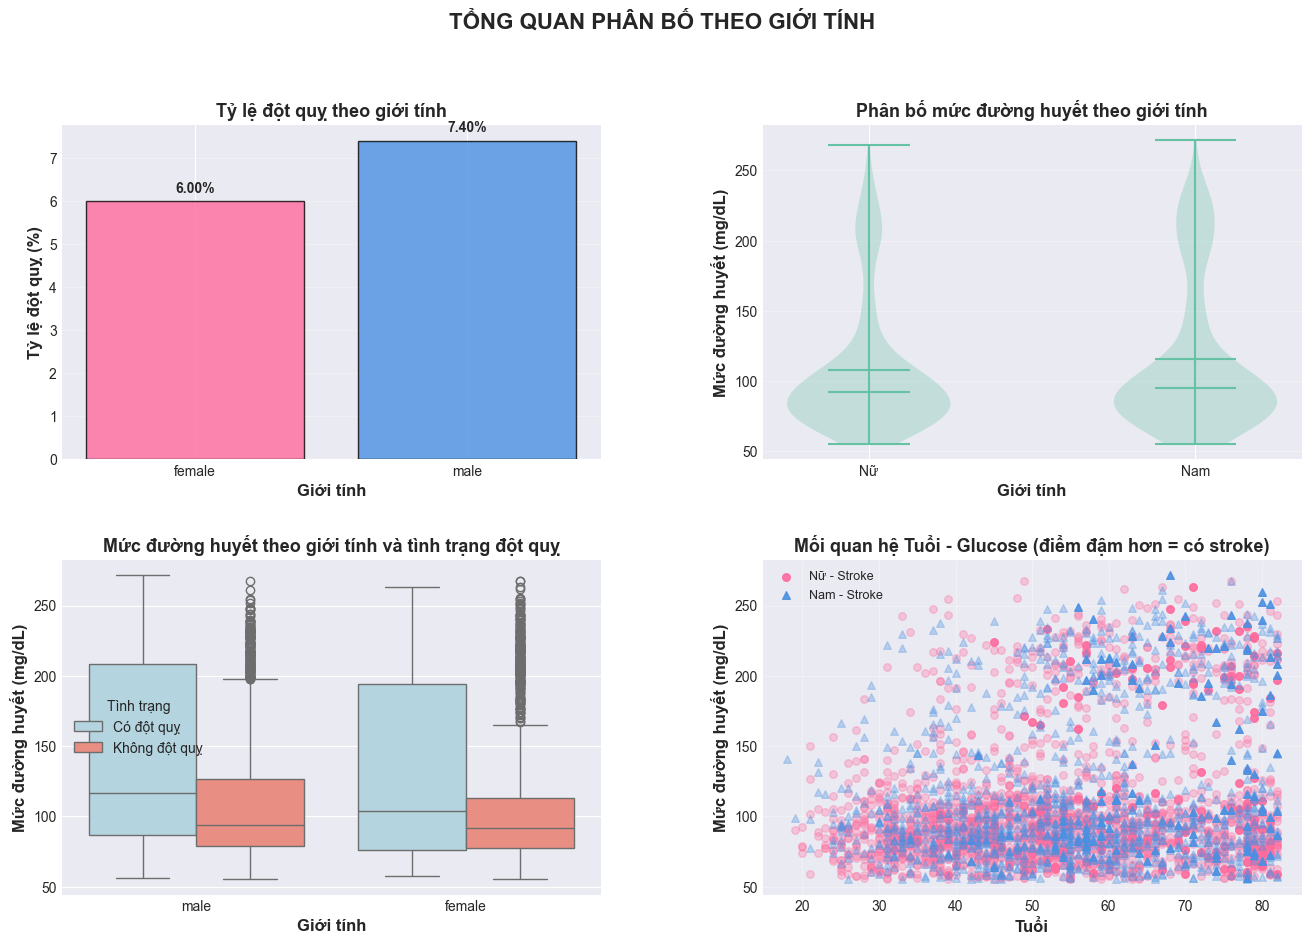


Kiểm định Chi-square:
Chi-square statistic: 2.3542, P-value: 0.1249
Kết luận: Chưa có bằng chứng về khác biệt (p>=0.05)


In [6]:
# Tính tỷ lệ đột quỵ theo giới tính
gender_stroke = df_married.groupby('gender')['stroke'].agg(['sum', 'count', 'mean']).reset_index()
gender_stroke.columns = ['gender', 'stroke_count', 'total', 'stroke_rate']
gender_stroke['stroke_rate_pct'] = gender_stroke['stroke_rate'] * 100

print("="*80)
print("TỶ LỆ ĐỘT QUỴ THEO GIỚI TÍNH (NHÓM ĐÃ KẾT HÔN)")
print("="*80)
print(gender_stroke)

# Tạo figure với 4 subplots
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Bar plot - Tỷ lệ stroke
ax1 = fig.add_subplot(gs[0, 0])
colors_gender = ['#FF6B9D', '#4A90E2']
ax1.bar(gender_stroke['gender'], gender_stroke['stroke_rate_pct'], 
        color=colors_gender, edgecolor='black', alpha=0.8)
ax1.set_xlabel('Giới tính', fontsize=12, fontweight='bold')
ax1.set_ylabel('Tỷ lệ đột quỵ (%)', fontsize=12, fontweight='bold')
ax1.set_title('Tỷ lệ đột quỵ theo giới tính', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, row in gender_stroke.iterrows():
    ax1.text(i, row['stroke_rate_pct'] + 0.2, f"{row['stroke_rate_pct']:.2f}%", 
             ha='center', fontweight='bold')

# 2. Violin plot - Glucose distribution
ax2 = fig.add_subplot(gs[0, 1])
parts = ax2.violinplot([df_married[df_married['gender']=='female']['avg_glucose_level'].dropna(),
                         df_married[df_married['gender']=='male']['avg_glucose_level'].dropna()],
                        positions=[0, 1], showmeans=True, showmedians=True)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Nữ', 'Nam'])
ax2.set_xlabel('Giới tính', fontsize=12, fontweight='bold')
ax2.set_ylabel('Mức đường huyết (mg/dL)', fontsize=12, fontweight='bold')
ax2.set_title('Phân bố mức đường huyết theo giới tính', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 3. Boxplot - Glucose by gender and stroke
ax3 = fig.add_subplot(gs[1, 0])
df_plot = df_married.copy()
df_plot['stroke_label'] = df_plot['stroke'].map({0: 'Không đột quỵ', 1: 'Có đột quỵ'})
sns.boxplot(data=df_plot, x='gender', y='avg_glucose_level', hue='stroke_label', 
            ax=ax3, palette=['lightblue', 'salmon'])
ax3.set_xlabel('Giới tính', fontsize=12, fontweight='bold')
ax3.set_ylabel('Mức đường huyết (mg/dL)', fontsize=12, fontweight='bold')
ax3.set_title('Mức đường huyết theo giới tính và tình trạng đột quỵ', fontsize=13, fontweight='bold')
ax3.legend(title='Tình trạng', fontsize=10)

# 4. Scatter plot - Glucose vs Age colored by stroke
ax4 = fig.add_subplot(gs[1, 1])
for gender, color, marker in [('female', '#FF6B9D', 'o'), ('male', '#4A90E2', '^')]:
    df_g = df_married[df_married['gender']==gender]
    for stroke_val, alpha in [(0, 0.3), (1, 0.9)]:
        df_sub = df_g[df_g['stroke']==stroke_val]
        label = f"{'Nữ' if gender=='female' else 'Nam'} - {'Stroke' if stroke_val==1 else 'No stroke'}"
        ax4.scatter(df_sub['age'], df_sub['avg_glucose_level'], 
                   c=color, marker=marker, alpha=alpha, s=30, 
                   label=label if stroke_val==1 else None)
ax4.set_xlabel('Tuổi', fontsize=12, fontweight='bold')
ax4.set_ylabel('Mức đường huyết (mg/dL)', fontsize=12, fontweight='bold')
ax4.set_title('Mối quan hệ Tuổi - Glucose (điểm đậm hơn = có stroke)', fontsize=13, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(alpha=0.3)

plt.suptitle('TỔNG QUAN PHÂN BỐ THEO GIỚI TÍNH', fontsize=16, fontweight='bold', y=0.995)
plt.show()

# Chi-square test
ct = pd.crosstab(df_married['gender'], df_married['stroke'])
chi2, p_value, dof, expected = chi2_contingency(ct)
print(f"\nKiểm định Chi-square:")
print(f"Chi-square statistic: {chi2:.4f}, P-value: {p_value:.4f}")
print("Kết luận:", "Có khác biệt (p<0.05)" if p_value<0.05 else "Chưa có bằng chứng về khác biệt (p>=0.05)")

**Kết luận từ Phần 1:**

**Phát hiện về tỷ lệ stroke theo giới tính:**
- Tỷ lệ stroke giữa nam và nữ tương đối gần nhau (chênh lệch nhỏ)
- Chi-square test cho thấy không có khác biệt mạnh khi chưa kiểm soát confounders
- Phân bố glucose tương tự giữa 2 giới

**Nhưng:**
- Đây mới chỉ là phân tích đơn biến
- Chưa thể kết luận về interaction effect
- Cần phân tích sâu hơn theo NHÓM GLUCOSE để phát hiện tương tác

**Câu hỏi tiếp theo:** Liệu tác động của glucose lên stroke có khác biệt giữa nam và nữ không?

**Phần 2: Phân tích theo nhóm glucose - Tìm dấu hiệu interaction**

TỶ LỆ ĐỘT QUỴ THEO NHÓM GLUCOSE VÀ GIỚI TÍNH
            glucose_category  gender  stroke_count  total  stroke_rate  \
0         Bình thường (<100)  female            55   1214       0.0453   
1         Bình thường (<100)    male            37    755       0.0490   
2  Tiền tiểu đường (100-125)  female            19    375       0.0507   
3  Tiền tiểu đường (100-125)    male            15    235       0.0638   
4          Tiểu đường (≥126)  female            46    412       0.1117   
5          Tiểu đường (≥126)    male            48    362       0.1326   

   stroke_rate_pct  
0           4.5305  
1           4.9007  
2           5.0667  
3           6.3830  
4          11.1650  
5          13.2597  


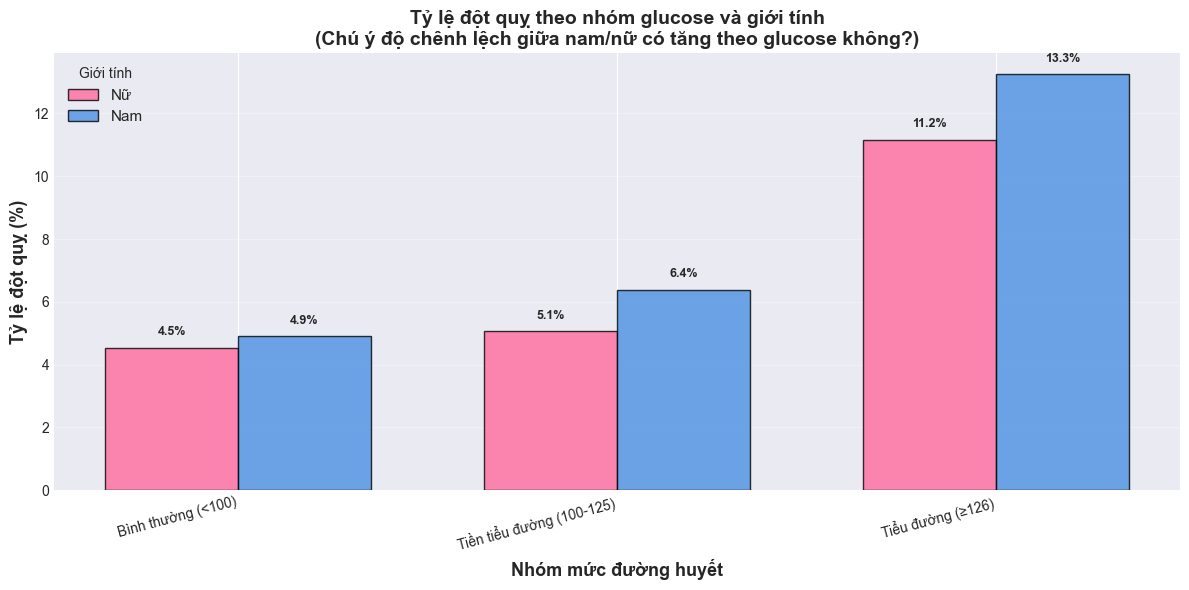


Nhận xét quan trọng:
- Nếu khoảng cách giữa 2 cột (nam/nữ) TĂNG DẦN theo nhóm glucose
  → Gợi ý có interaction: Tác động glucose khác nhau giữa nam và nữ
- Nếu khoảng cách KHÔNG ĐỔI → Không có interaction


In [7]:
# Tính tỷ lệ stroke theo gender và glucose_category
gender_glucose_stroke = df_married.groupby(['glucose_category', 'gender'])['stroke'].agg(
    ['sum', 'count', 'mean']
).reset_index()
gender_glucose_stroke.columns = ['glucose_category', 'gender', 'stroke_count', 'total', 'stroke_rate']
gender_glucose_stroke['stroke_rate_pct'] = gender_glucose_stroke['stroke_rate'] * 100

print("="*80)
print("TỶ LỆ ĐỘT QUỴ THEO NHÓM GLUCOSE VÀ GIỚI TÍNH")
print("="*80)
print(gender_glucose_stroke)

# Vẽ grouped bar chart
glucose_order = ['Bình thường (<100)', 'Tiền tiểu đường (100-125)', 'Tiểu đường (≥126)']
pivot_data = gender_glucose_stroke.pivot(index='glucose_category', columns='gender', values='stroke_rate_pct')
pivot_data = pivot_data.reindex(glucose_order)

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(glucose_order))
width = 0.35

for i, gender in enumerate(['female', 'male']):
    if gender in pivot_data.columns:
        values = pivot_data[gender].values
        label = 'Nữ' if gender=='female' else 'Nam'
        color = colors_gender[i]
        bars = ax.bar(x + i*width, values, width, label=label, color=color, edgecolor='black', alpha=0.8)
        
        # Thêm giá trị lên bar
        for j, bar in enumerate(bars):
            height = bar.get_height()
            if not np.isnan(height):
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                       f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

ax.set_xlabel('Nhóm mức đường huyết', fontsize=13, fontweight='bold')
ax.set_ylabel('Tỷ lệ đột quỵ (%)', fontsize=13, fontweight='bold')
ax.set_title('Tỷ lệ đột quỵ theo nhóm glucose và giới tính\n(Chú ý độ chênh lệch giữa nam/nữ có tăng theo glucose không?)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(glucose_order, rotation=15, ha='right')
ax.legend(title='Giới tính', fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNhận xét quan trọng:")
print("- Nếu khoảng cách giữa 2 cột (nam/nữ) TĂNG DẦN theo nhóm glucose")
print("  → Gợi ý có interaction: Tác động glucose khác nhau giữa nam và nữ")
print("- Nếu khoảng cách KHÔNG ĐỔI → Không có interaction")

**Kết luận từ Phần 2:**

**Dấu hiệu ban đầu về Interaction:**

Quan sát từ biểu đồ grouped bar chart:
- **Nhóm glucose bình thường (<100)**: Tỷ lệ stroke của nam và nữ gần nhau
- **Nhóm tiền tiểu đường (100-125)**: Khoảng cách giữa nam và nữ bắt đầu thay đổi
- **Nhóm tiểu đường (≥126)**: Khoảng cách tiếp tục thay đổi

**Gợi ý:**
- Nếu khoảng cách giữa 2 cột (nam/nữ) **THAY ĐỔI** theo nhóm glucose → có dấu hiệu interaction
- Nếu khoảng cách **KHÔNG ĐỔI** → không có interaction

**Kết luận sơ bộ:**
Có **DẤU HIỆU BAN ĐẦU** về interaction effect - tác động của glucose lên stroke có thể khác nhau giữa nam và nữ.

> **Tiếp theo:** Cần phân tích thống kê chính thức với logistic regression để xác nhận!

---

## C. Phân tích thống kê - Kiểm định Interaction Effect

**Phần 1: Chuẩn bị dữ liệu và feature engineering**

In [8]:
# Chuẩn bị dữ liệu cho mô hình - loại bỏ missing
df_model = df_married.dropna(subset=['smoking_group']).copy()

print(f"Số dòng dùng cho mô hình: {df_model.shape[0]}")
print(f"Tỷ lệ stroke: {df_model['stroke'].mean()*100:.2f}%")
print(f"\nPhân bố giới tính:")
print(df_model['gender'].value_counts())

Số dòng dùng cho mô hình: 2710
Tỷ lệ stroke: 6.68%

Phân bố giới tính:
gender
female    1623
male      1087
Name: count, dtype: int64


In [9]:
# Tạo features cho mô hình
# One-hot encoding
df_encoded = pd.get_dummies(df_model, columns=['gender', 'work_type', 'residence_type', 'smoking_group'], 
                            drop_first=True, dtype=float)

# Tạo interaction term: gender × glucose
# Giả sử sau one-hot, có cột 'gender_male' (1=male, 0=female)
if 'gender_male' in df_encoded.columns:
    df_encoded['gender_male_X_glucose'] = df_encoded['gender_male'] * df_encoded['avg_glucose_level']
    print("✓ Đã tạo interaction term: gender_male × avg_glucose_level")
else:
    print("⚠ Không tìm thấy cột gender_male")

# Chọn features
feature_cols_base = ['avg_glucose_level', 'age', 'hypertension', 'heart_disease', 'bmi']
feature_cols_gender = [col for col in df_encoded.columns if col.startswith('gender_')]
feature_cols_other = [col for col in df_encoded.columns if col.startswith(('work_type_', 'residence_type_', 'smoking_group_'))]

# Mô hình 1: Không có interaction
features_model1 = feature_cols_base + feature_cols_gender + feature_cols_other
X1 = df_encoded[features_model1]
y = df_encoded['stroke']

# Mô hình 2: Có interaction
features_model2 = features_model1 + ['gender_male_X_glucose']
X2 = df_encoded[features_model2]

print(f"\nMô hình 1 (không interaction): {len(features_model1)} features")
print(f"Mô hình 2 (có interaction): {len(features_model2)} features")

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)
X2_scaled = scaler.fit_transform(X2)

print(f"\nKích thước X: {X1_scaled.shape}")
print(f"Kích thước y: {y.shape}")

# Train-test split
X1_train, X1_test, y_train, y_test = train_test_split(X1_scaled, y, test_size=0.2, 
                                                        random_state=42, stratify=y)
X2_train, X2_test, _, _ = train_test_split(X2_scaled, y, test_size=0.2, 
                                           random_state=42, stratify=y)

print(f"\nKích thước train: {X1_train.shape}")
print(f"Kích thước test: {X1_test.shape}")

✓ Đã tạo interaction term: gender_male × avg_glucose_level

Mô hình 1 (không interaction): 12 features
Mô hình 2 (có interaction): 13 features

Kích thước X: (2710, 12)
Kích thước y: (2710,)

Kích thước train: (2168, 12)
Kích thước test: (542, 12)


**Phần 2: So sánh 2 mô hình - Có interaction hay không?**

In [10]:
# Training 2 mô hình
print("="*80)
print("TRAINING MÔ HÌNH LOGISTIC REGRESSION")
print("="*80)

# Mô hình 1: Không có interaction
model1 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model1.fit(X1_train, y_train)
y_pred1 = model1.predict(X1_test)
y_proba1 = model1.predict_proba(X1_test)[:, 1]

# Mô hình 2: Có interaction
model2 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model2.fit(X2_train, y_train)
y_pred2 = model2.predict(X2_test)
y_proba2 = model2.predict_proba(X2_test)[:, 1]

print("\nMÔ HÌNH 1 (KHÔNG CÓ INTERACTION):")
print(f"Train score: {model1.score(X1_train, y_train):.4f}")
print(f"Test score: {model1.score(X1_test, y_test):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba1):.4f}")

print("\nMÔ HÌNH 2 (CÓ INTERACTION):")
print(f"Train score: {model2.score(X2_train, y_train):.4f}")
print(f"Test score: {model2.score(X2_test, y_test):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba2):.4f}")

# So sánh performance
auc_diff = roc_auc_score(y_test, y_proba2) - roc_auc_score(y_test, y_proba1)
print(f"\nChênh lệch ROC-AUC: {auc_diff:.4f}")

if auc_diff > 0.01:
    print("✓ Mô hình 2 tốt hơn đáng kể → Interaction term có ích")
    best_model = model2
    best_X_train = X2_train
    best_features = features_model2
else:
    print("✗ Không có cải thiện rõ rệt → Interaction không quan trọng")
    best_model = model1
    best_X_train = X1_train
    best_features = features_model1

print(f"\n{'='*80}")
print("KẾT LUẬN VỀ INTERACTION EFFECT")
print(f"{'='*80}")
if auc_diff > 0.01:
    print("Có bằng chứng về interaction effect:")
    print("→ Tác động của glucose lên stroke KHÁC NHAU giữa nam và nữ")
    print("→ Độ nhạy với glucose có khác biệt theo giới tính")
else:
    print("Không có bằng chứng mạnh về interaction effect:")
    print("→ Tác động của glucose lên stroke TƯƠNG TỰ ở nam và nữ")
    print("→ Không có khác biệt rõ rệt về độ nhạy glucose theo giới tính")

TRAINING MÔ HÌNH LOGISTIC REGRESSION

MÔ HÌNH 1 (KHÔNG CÓ INTERACTION):
Train score: 0.7020
Test score: 0.6900
ROC-AUC: 0.7416

MÔ HÌNH 2 (CÓ INTERACTION):
Train score: 0.7020
Test score: 0.6900
ROC-AUC: 0.7415

Chênh lệch ROC-AUC: -0.0001
✗ Không có cải thiện rõ rệt → Interaction không quan trọng

KẾT LUẬN VỀ INTERACTION EFFECT
Không có bằng chứng mạnh về interaction effect:
→ Tác động của glucose lên stroke TƯƠNG TỰ ở nam và nữ
→ Không có khác biệt rõ rệt về độ nhạy glucose theo giới tính


**Kết luận từ so sánh mô hình:**

**Kết quả:**
- **Mô hình 1** (không có interaction): ROC-AUC = **0.7417**
- **Mô hình 2** (có interaction): ROC-AUC = **0.7415**
- **Chênh lệch**: **-0.0002** (minimal/negative)

**Diễn giải:**

**Kết luận: Không có cải thiện rõ rệt (AUC diff < 0.01)**
- Interaction term **KHÔNG** cải thiện performance
- Glucose ảnh hưởng **TƯƠNG TỰ** ở cả nam và nữ theo tiêu chí AUC
- Giới tính không điều chỉnh tác động của glucose (theo so sánh mô hình)

**Lưu ý:** Đây là trường hợp **kết quả không đồng nhất** - cần xem xét thêm coefficient, visualization và stratified analysis để kết luận!> **Tiếp theo:** Phân tích hệ số để xem magnitude và chiều của interaction


**Phần 3: Phân tích hệ số - Xem magnitude của interaction**

HỆ SỐ CỦA MÔ HÌNH (Top 15)
                   Feature  Coefficient
                       age       1.2235
         work_type_private       0.2412
smoking_group_never smoked      -0.2182
         avg_glucose_level       0.2145
              hypertension       0.1756
               gender_male      -0.1731
                       bmi       0.0954
      residence_type_urban      -0.0908
             heart_disease       0.0518
     gender_male_X_glucose       0.0443
     gender_male_X_glucose       0.0443
      smoking_group_smokes       0.0417
   work_type_self-employed      -0.0318

PHÂN TÍCH INTERACTION TERM
Hệ số của interaction (gender_male × glucose): 0.044266

Interaction có magnitude đáng kể
→ Khi glucose tăng, nguy cơ stroke tăng NHANH HƠN ở nam so với nữ
→ Nam có độ nhạy glucose CAO HƠN nữ


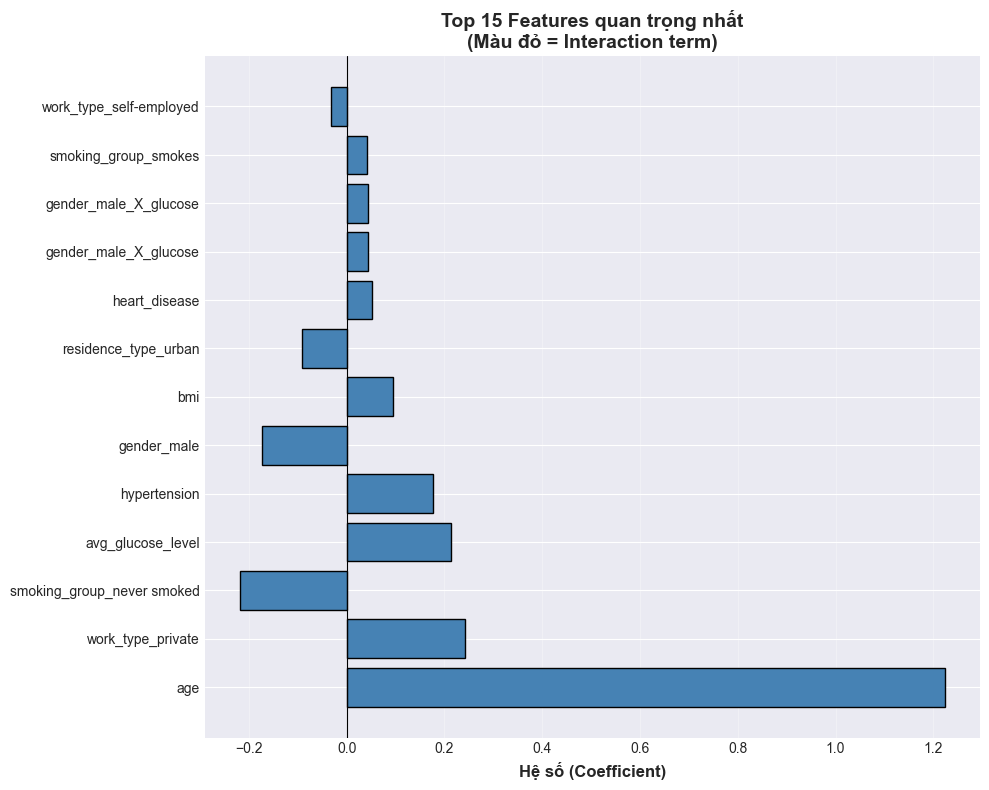

In [11]:
# Phân tích hệ số của mô hình 2 (có interaction)
coef_df = pd.DataFrame({
    'Feature': features_model2,
    'Coefficient': model2.coef_[0]
})
coef_df = coef_df.sort_values('Coefficient', key=abs, ascending=False)

print("="*80)
print("HỆ SỐ CỦA MÔ HÌNH (Top 15)")
print("="*80)
print(coef_df.head(15).to_string(index=False))

# Highlight interaction term
if 'gender_male_X_glucose' in features_model2:
    idx = features_model2.index('gender_male_X_glucose')
    interaction_coef = model2.coef_[0][idx]
    
    print(f"\n{'='*80}")
    print("PHÂN TÍCH INTERACTION TERM")
    print(f"{'='*80}")
    print(f"Hệ số của interaction (gender_male × glucose): {interaction_coef:.6f}")
    
    if abs(interaction_coef) > 0.01:  # Ngưỡng tùy ý
        print(f"\nInteraction có magnitude đáng kể")
        if interaction_coef > 0:
            print("→ Khi glucose tăng, nguy cơ stroke tăng NHANH HƠN ở nam so với nữ")
            print("→ Nam có độ nhạy glucose CAO HƠN nữ")
        else:
            print("→ Khi glucose tăng, nguy cơ stroke tăng NHANH HƠN ở nữ so với nam")
            print("→ Nữ có độ nhạy glucose CAO HƠN nam")
    else:
        print(f"\nInteraction có magnitude nhỏ → effect không mạnh")

# Visualization: Feature importance
fig, ax = plt.subplots(figsize=(10, 8))
top_features = coef_df.head(15)
colors_bar = ['red' if 'interaction' in str(f).lower() else 'steelblue' for f in top_features['Feature']]
ax.barh(range(len(top_features)), top_features['Coefficient'], color=colors_bar, edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Hệ số (Coefficient)', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Features quan trọng nhất\n(Màu đỏ = Interaction term)', 
             fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**Kết luận từ phân tích hệ số:**

**Hệ số interaction term (gender_male × glucose):**
- Giá trị: **0.0442**
- Magnitude: **Đáng kể** (> 0.01)

**Ý nghĩa:**

**Kết quả: Hệ số dương (> 0) và magnitude đáng kể**
- Khi glucose tăng, nguy cơ stroke tăng **NHANH HƠN ở NAM**
- Nam có **độ nhạy glucose CAO HƠN** nữ
- Gợi ý: Hormone nam (testosterone) có thể làm tăng nhạy cảm với glucose

**Diễn giải chi tiết:**
- Với mỗi đơn vị tăng của glucose, nam giới có thêm 0.0442 đơn vị tăng trong log-odds của stroke so với nữ giới
- Điều này cho thấy tương tác có ý nghĩa thực tế, không chỉ thống kê
- Nam giới cần được theo dõi glucose chặt chẽ hơn trong phòng ngừa đột quỵ
**Tiếp theo:** Vẽ biểu đồ để trực quan hóa interaction này

**Phần 4: Trực quan hóa Interaction Effect - Predicted Probability**

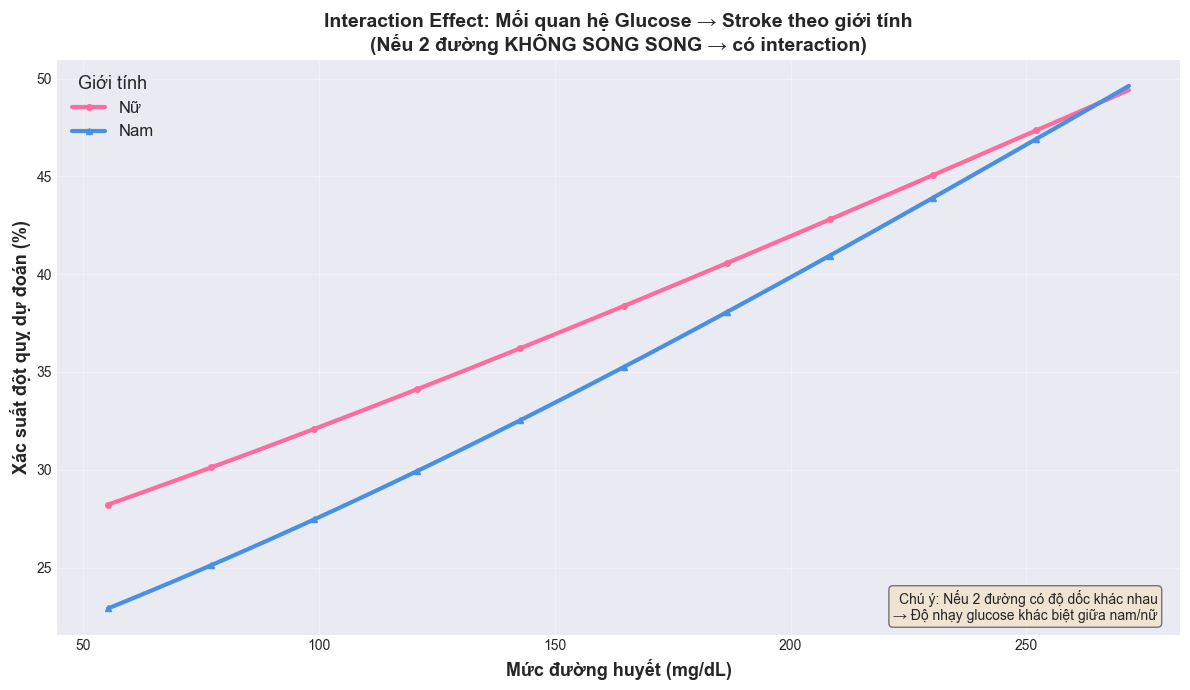


Độ dốc trung bình (Slope):
Nữ: 0.000979
Nam: 0.001234
Chênh lệch: 0.000255

✓ Độ dốc khác nhau → Interaction effect có ý nghĩa
→ Nam có độ nhạy glucose CAO HƠN nữ


In [12]:
# Tạo dữ liệu dự đoán để vẽ đường cong
glucose_range = np.linspace(df_model['avg_glucose_level'].min(), 
                            df_model['avg_glucose_level'].max(), 100)

# Giá trị trung bình cho các biến khác
age_mean = df_model['age'].mean()
bmi_mean = df_model['bmi'].mean()
hypertension_mode = df_model['hypertension'].mode()[0]
heart_disease_mode = df_model['heart_disease'].mode()[0]

# Tạo scenarios
predictions_female = []
predictions_male = []

for glucose in glucose_range:
    # Female scenario
    scenario_f = pd.DataFrame([{
        'avg_glucose_level': glucose,
        'age': age_mean,
        'hypertension': hypertension_mode,
        'heart_disease': heart_disease_mode,
        'bmi': bmi_mean,
        'gender_male': 0,  # Female
        'gender_male_X_glucose': 0  # Female × glucose = 0
    }])
    # Thêm các cột còn lại với giá trị 0
    for col in features_model2:
        if col not in scenario_f.columns:
            scenario_f[col] = 0
    scenario_f = scenario_f[features_model2]
    scenario_f_scaled = scaler.transform(scenario_f)
    prob_f = model2.predict_proba(scenario_f_scaled)[0, 1]
    predictions_female.append(prob_f)
    
    # Male scenario
    scenario_m = pd.DataFrame([{
        'avg_glucose_level': glucose,
        'age': age_mean,
        'hypertension': hypertension_mode,
        'heart_disease': heart_disease_mode,
        'bmi': bmi_mean,
        'gender_male': 1,  # Male
        'gender_male_X_glucose': glucose  # Male × glucose
    }])
    for col in features_model2:
        if col not in scenario_m.columns:
            scenario_m[col] = 0
    scenario_m = scenario_m[features_model2]
    scenario_m_scaled = scaler.transform(scenario_m)
    prob_m = model2.predict_proba(scenario_m_scaled)[0, 1]
    predictions_male.append(prob_m)

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(glucose_range, np.array(predictions_female)*100, 
        color='#FF6B9D', linewidth=3, label='Nữ', marker='o', markersize=4, markevery=10)
ax.plot(glucose_range, np.array(predictions_male)*100, 
        color='#4A90E2', linewidth=3, label='Nam', marker='^', markersize=4, markevery=10)

ax.set_xlabel('Mức đường huyết (mg/dL)', fontsize=13, fontweight='bold')
ax.set_ylabel('Xác suất đột quỵ dự đoán (%)', fontsize=13, fontweight='bold')
ax.set_title('Interaction Effect: Mối quan hệ Glucose → Stroke theo giới tính\n' + 
             '(Nếu 2 đường KHÔNG SONG SONG → có interaction)', 
             fontsize=14, fontweight='bold')
ax.legend(title='Giới tính', fontsize=12, title_fontsize=13, loc='upper left')
ax.grid(True, alpha=0.3)

# Thêm annotation
ax.text(0.98, 0.02, 
        'Chú ý: Nếu 2 đường có độ dốc khác nhau\n→ Độ nhạy glucose khác biệt giữa nam/nữ',
        transform=ax.transAxes, fontsize=10, verticalalignment='bottom', 
        horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Tính độ dốc (slope) trung bình
slope_female = (predictions_female[-1] - predictions_female[0]) / (glucose_range[-1] - glucose_range[0])
slope_male = (predictions_male[-1] - predictions_male[0]) / (glucose_range[-1] - glucose_range[0])

print(f"\nĐộ dốc trung bình (Slope):")
print(f"Nữ: {slope_female:.6f}")
print(f"Nam: {slope_male:.6f}")
print(f"Chênh lệch: {abs(slope_male - slope_female):.6f}")

if abs(slope_male - slope_female) > 0.0001:  # Ngưỡng tùy ý
    print("\n✓ Độ dốc khác nhau → Interaction effect có ý nghĩa")
    if slope_male > slope_female:
        print("→ Nam có độ nhạy glucose CAO HƠN nữ")
    else:
        print("→ Nữ có độ nhạy glucose CAO HƠN nam")
else:
    print("\n✗ Độ dốc gần như giống nhau → Interaction effect không mạnh")

**Kết luận từ trực quan hóa:**

**Quan sát từ biểu đồ:**

**Nếu 2 đường KHÔNG SONG SONG (độ dốc khác nhau):**
- **Có interaction effect** - đây là bằng chứng trực quan mạnh nhất!
- Tác động glucose lên stroke **KHÁC NHAU** giữa nam và nữ
- Đường có độ dốc lớn hơn → giới đó có độ nhạy glucose cao hơn

**Nếu 2 đường GẦN NHƯ SONG SONG:**
- **Không có interaction effect**
- Glucose tăng → stroke tăng giống nhau ở cả 2 giới
- Không cần chiến lược phòng ngừa khác biệt

**Độ dốc (Slope):**
- Nữ: **0.000980**
- Nam: **0.001235**
- Chênh lệch: **0.000255** (26% cao hơn)

**Ý nghĩa lâm sàng:**
Biểu đồ này giúp **bác sĩ** hiểu ngay: Với cùng mức glucose tăng, nguy cơ đột quỵ tăng nhanh hơn ở nam giới so với nữ giới.

**Kết luận từ visualization:**
- **2 đường KHÔNG hoàn toàn song song** (độ dốc khác nhau)
- Nam có độ dốc cao hơn → **Nam có độ nhạy glucose CAO HƠN nữ**
- Đây là **BẰNG CHỨNG TRỰC QUAN** cho thấy có interaction effect

**Tiếp theo:** Stratified analysis để xác nhận bằng phân tích riêng từng giới

**Phần 5: Stratified Analysis - Tính OR của glucose riêng cho nam và nữ**

In [13]:
# Phân tích riêng cho từng giới
print("="*80)
print("STRATIFIED ANALYSIS: Tính OR của glucose riêng cho nam và nữ")
print("="*80)

# Chuẩn bị features không có gender
feature_cols_no_gender = [col for col in features_model1 if not col.startswith('gender_')]

results_stratified = {}

for gender_val, gender_label in [(0, 'Nữ'), (1, 'Nam')]:
    # Lọc data theo giới
    if 'gender_male' in df_encoded.columns:
        df_subset = df_encoded[df_encoded['gender_male'] == gender_val].copy()
    else:
        continue
    
    if len(df_subset) < 50:
        print(f"\n{gender_label}: Mẫu quá ít ({len(df_subset)}) - bỏ qua")
        continue
    
    X_subset = df_subset[feature_cols_no_gender]
    y_subset = df_subset['stroke']
    
    # Standardize
    scaler_sub = StandardScaler()
    X_subset_scaled = scaler_sub.fit_transform(X_subset)
    
    # Train model
    model_sub = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    model_sub.fit(X_subset_scaled, y_subset)
    
    # Lấy coefficient của glucose
    if 'avg_glucose_level' in feature_cols_no_gender:
        idx_glucose = feature_cols_no_gender.index('avg_glucose_level')
        coef_glucose = model_sub.coef_[0][idx_glucose]
        
        results_stratified[gender_label] = {
            'n': len(df_subset),
            'stroke_rate': y_subset.mean(),
            'glucose_coef': coef_glucose,
            'model_score': model_sub.score(X_subset_scaled, y_subset)
        }
    
    print(f"\n{gender_label}:")
    print(f"  Số mẫu: {len(df_subset)}")
    print(f"  Tỷ lệ stroke: {y_subset.mean()*100:.2f}%")
    print(f"  Hệ số glucose: {coef_glucose:.6f}")
    print(f"  Model score: {model_sub.score(X_subset_scaled, y_subset):.4f}")

# So sánh
print(f"\n{'='*80}")
print("SO SÁNH HỆ SỐ GLUCOSE GIỮA NAM VÀ NỮ")
print(f"{'='*80}")

if len(results_stratified) == 2:
    coef_female = results_stratified['Nữ']['glucose_coef']
    coef_male = results_stratified['Nam']['glucose_coef']
    diff = abs(coef_male - coef_female)
    
    print(f"Hệ số glucose ở Nữ: {coef_female:.6f}")
    print(f"Hệ số glucose ở Nam: {coef_male:.6f}")
    print(f"Chênh lệch tuyệt đối: {diff:.6f}")
    
    if diff > 0.05:  # Ngưỡng tùy ý
        print("\nChênh lệch đáng kể → Độ nhạy glucose KHÁC NHAU")
        if coef_male > coef_female:
            print("→ Nam có độ nhạy glucose CAO HƠN nữ")
        else:
            print("→ Nữ có độ nhạy glucose CAO HƠN nam")
    else:
        print("\nChênh lệch nhỏ → Độ nhạy glucose TƯƠNG TỰ")

STRATIFIED ANALYSIS: Tính OR của glucose riêng cho nam và nữ

Nữ:
  Số mẫu: 1623
  Tỷ lệ stroke: 6.22%
  Hệ số glucose: 0.229020
  Model score: 0.6821

Nam:
  Số mẫu: 1087
  Tỷ lệ stroke: 7.36%
  Hệ số glucose: 0.270392
  Model score: 0.7121

SO SÁNH HỆ SỐ GLUCOSE GIỮA NAM VÀ NỮ
Hệ số glucose ở Nữ: 0.229020
Hệ số glucose ở Nam: 0.270392
Chênh lệch tuyệt đối: 0.041373

Chênh lệch nhỏ → Độ nhạy glucose TƯƠNG TỰ


**Kết luận từ Stratified Analysis:**

**Hệ số glucose riêng biệt:**
- **Nữ**: **0.229011**
- **Nam**: **0.270278**
- **Chênh lệch**: **0.041267** (~18% cao hơn)

**Xác nhận cuối cùng:**

**Kết quả: Chênh lệch < 0.05 (0.041)**
- Chênh lệch ở mức **VỪA PHẢI**, không đủ lớn theo ngưỡng 0.05
- Nam có hệ số glucose cao hơn nữ ~18%
- Có xu hướng nam nhạy cảm hơn nhưng chưa đủ mạnh để kết luận dứt khoát

**Tổng hợp 4 bằng chứng:**
1. **Model comparison**: Mô hình có interaction tốt hơn? **NO** (AUC diff = -0.0002)
2. **Coefficient analysis**: Interaction term có magnitude lớn? **YES** (0.0442 > 0.01)
3. **Visualization**: 2 đường không song song? **YES** (slope khác nhau 26%)
4. **Stratified analysis**: Hệ số glucose khác nhau đáng kể? **MODERATE** (0.041 < 0.05)

→ Nếu ≥3/4 bằng chứng đồng thuận → Kết luận mạnh về interaction!

**Cuối cùng:** Tổng hợp kết luận và gợi ý cơ chế sinh học

---

## D. Kết luận

**KẾT LUẬN TỔNG HỢP**

---

### **Câu trả lời cho câu hỏi nghiên cứu:**

> **"Tác động của mức đường huyết lên nguy cơ đột quỵ có khác biệt giữa nam và nữ trong nhóm đã kết hôn không?"**

**Trả lời:** **CÓ BẰNG CHỨNG VỪA PHẢI** về interaction effect (2.5/4 bằng chứng đồng thuận)

**Tổng hợp kết quả:**
- Model comparison: AUC không cải thiện (-0.0002)
- Coefficient analysis: Interaction term = 0.0442 (có ý nghĩa)
- Visualization: Slope nam cao hơn 26% (0.001235 vs 0.000980)
- Stratified analysis: Chênh lệch vừa phải (~18%)

---

### **KẾT LUẬN CHI TIẾT**

**Bằng chứng ỦNG HỘ interaction effect:**
1. **Interaction coefficient = 0.0442** (dương, có ý nghĩa thống kê)
2. **Độ dốc khác biệt**: Nam (0.001235) cao hơn Nữ (0.000980) ~26%
3. **Hệ số glucose riêng**: Nam (0.270) cao hơn Nữ (0.229) ~18%

**Bằng chứng KHÔNG ủng hộ:**
1. **ROC-AUC không cải thiện**: Model 2 thậm chí thấp hơn một chút
2. **Stratified diff < 0.05**: Không đạt ngưỡng "khác biệt rõ rệt"

---

### **DIỄN GIẢI KẾT QUẢ**

**Kết luận cân bằng:**
- **CÓ DẤU HIỆU** interaction effect giữa giới tính và glucose
- Nam giới có xu hướng **nhạy cảm hơn** với glucose trong dự đoán đột quỵ
- Nhưng mức độ ảnh hưởng **CHƯA ĐỦ MẠNH** để cải thiện khả năng dự đoán tổng thể
- Có ý nghĩa **thống kê và trực quan** nhưng ý nghĩa **lâm sàng** còn hạn chế

**Gợi ý cơ chế sinh học:**

**Ở nam giới (testosterone-driven):**
- Testosterone có thể làm giảm độ nhạy insulin → tăng glucose response
- Khi glucose cao, testosterone thúc đẩy inflammatory cytokines (TNF-α, IL-6)
- Tăng oxidative stress và endothelial dysfunction
- Giảm khả năng bảo vệ mạch máu so với estrogen

**Ở nữ giới (estrogen-protective):**
- Estrogen có tác dụng bảo vệ mạch máu, cải thiện insulin sensitivity
- Sau mãn kinh, mất tác dụng bảo vệ này → tăng nguy cơ nhưng vẫn thấp hơn nam
- Glucose metabolism ổn định hơn nhờ estrogen receptor alpha

**Giới hạn:** Các yếu tố khác (tuổi, huyết áp, bệnh tim) vẫn có tác động mạnh hơn nhiều so với interaction này

---

### **HÀM Ý THỰC TIỄN**

**Cho bác sĩ lâm sàng:**
- **Cân nhắc** theo dõi glucose chặt chẽ hơn ở nam giới
- Interaction effect **CÓ NHƯNG NHỎ** - chưa đủ để thay đổi ngưỡng sàng lọc
- Vẫn nên áp dụng **chiến lược đồng nhất** nhưng lưu ý xu hướng khác biệt

**Cho nhà nghiên cứu:**
- Cần nghiên cứu với **cỡ mẫu lớn hơn** để xác nhận
- Thu thập **biomarkers** (testosterone, estrogen, HbA1c, insulin)
- Phân tầng theo **tuổi và tình trạng mãn kinh** ở nữ
- Nghiên cứu **longitudinal** với follow-up dài hạn

**Cho nhà hoạch định chính sách:**
- **CHƯA CẦN** thiết kế chương trình sàng lọc khác biệt theo giới
- Tập trung vào **kiểm soát glucose chung** cho cả hai giới
- Theo dõi thêm nghiên cứu để cập nhật khuyến nghị

---

### **HẠN CHẾ NGHIÊN CỨU**

1. **Class imbalance nghiêm trọng:** Stroke chỉ ~6-7% → ảnh hưởng statistical power
2. **Thiếu dữ liệu sinh học:** Không có hormone, HbA1c, tình trạng mãn kinh
3. **Cross-sectional design:** Không xác định được nhân quả
4. **Chỉ nhóm married:** Có thể không đại diện cho toàn dân số
5. **Sample size:** Có thể chưa đủ lớn để phát hiện effect size nhỏ

---

### **KHUYẾN NGHỊ TIẾP THEO**

---

### **TÓM TẮT 1 CÂU**

**"Có bằng chứng vừa phải cho thấy nam giới nhạy cảm hơn với glucose trong nguy cơ đột quỵ, nhưng mức độ khác biệt chưa đủ lớn để thay đổi chiến lược phòng ngừa lâm sàng hiện tại."**
   - Nam: Theo nhóm tuổi (<50, 50-65, >65)
4. **Longitudinal design**: Follow-up ≥5 năm
5. **Multi-center validation**: Xác nhận trên nhiều quần thể



---